## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

## Test amplitude distribution

Test distribution shapre
#### Uphill
Slope is $1.6$, starting at $P=0$, $E=9.5$: $P = 1.6(E-9.5)$
#### Downhill
Slope $-0.25$, starting at $P=1$: $E = \frac{1.0}{1.6} + 9.5$

In [2]:
E_test = np.linspace(0, 15, 1000)

In [3]:
E_offset = 1.0/1.6 + 9.5
P_test = np.array([ 1.6*(E-9.5) if E < E_offset else (1.0 - 0.25*(E - E_offset)) for E in E_test ])
P_test[P_test < 0] = 0

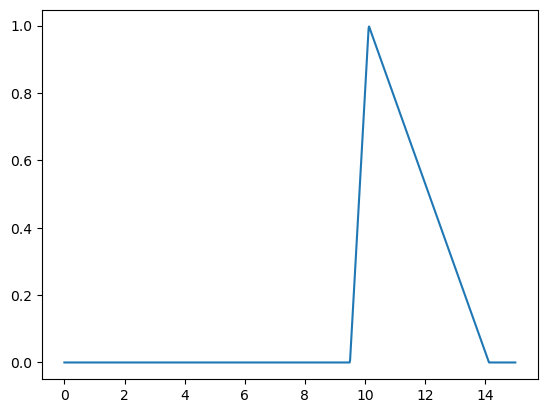

In [4]:
plt.plot(E_test, P_test)

### Normalize the test set

In [5]:
def probNormalize(E, P):
    # Integrate P
    PInt = 0
    for i in range(len(E) - 1):
        PInt += (P[i] + P[i+1]) * (E[i+1] - E[i]) / 2
    print(f"{PInt=}")
    return P / PInt

In [6]:
P_test = probNormalize(E_test, P_test)

PInt=2.312497745493241


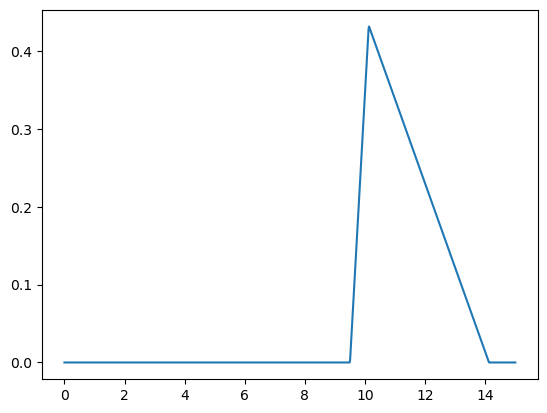

In [7]:
plt.plot(E_test, P_test)

In [8]:
assert(np.allclose(probNormalize(E_test, P_test), P_test))

PInt=1.0000000000000002


## Load the example signal

In [9]:
exampleSignal = ( [], [] )
with open('task/Shape_Etalon.txt') as sigFile:
    for line in sigFile.readlines():
        point = line.split('\t')
        for i in range(2):
            exampleSignal[i].append(float(point[i]))
exampleSignal = ( np.array(exampleSignal[0]), np.array(exampleSignal[1]) )

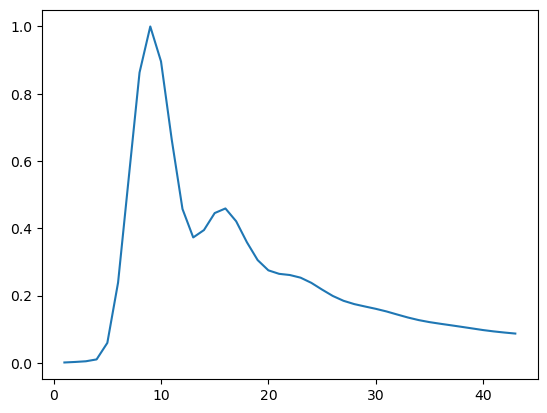

In [10]:
plt.plot(exampleSignal[0], exampleSignal[1])

### Utility - plot signal

In [11]:
def plotSignals(*signals, **namedSignals):
    for idx, signal in enumerate(signals):
        plt.plot(signal[0], signal[1], label=f"Signal {idx}")
    for name in namedSignals:
        plt.plot(namedSignals[name][0], namedSignals[name][1], label=name)
    plt.legend()

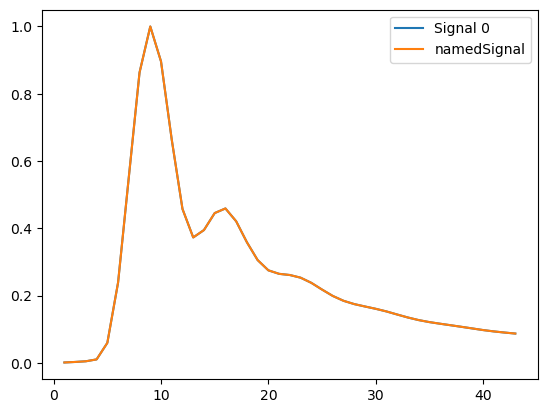

In [12]:
plotSignals(exampleSignal, namedSignal=exampleSignal)

## Signal composition

In [13]:
@njit
def composeSignals(signal1, signal2, offset, amp1, amp2):
    signal = ( signal1[0].copy(), signal1[1].copy() * amp1 )
    for E2 in signal2[0]:
        index2 = np.where(signal2[0] == E2)[0][0]
        E1 = E2 + offset
        if E1 in signal1[0]:
            index1 = np.where(signal[0] == E1)[0][0]
            signal[1][index1] += signal2[1][index2] * amp2
    return signal

In [14]:
exampleOffset = composeSignals(exampleSignal, exampleSignal, 13, 1, 1)

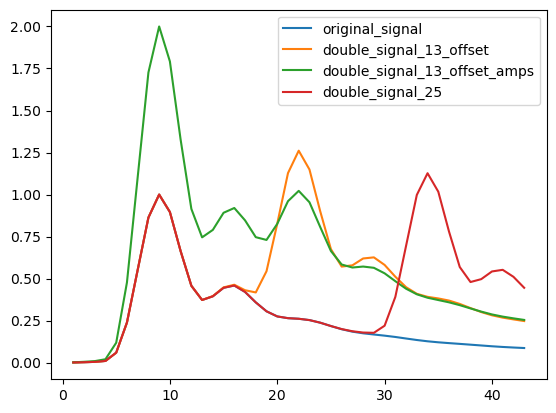

In [15]:
plotSignals(
    original_signal=exampleSignal,
    double_signal_13_offset=exampleOffset,
    double_signal_13_offset_amps=composeSignals(exampleSignal, exampleSignal, 13, 2, .5),
    double_signal_25=composeSignals(exampleSignal, exampleSignal, 25, 1, 1)
)

## Integrate composed signal

In [16]:
"""
Integrates given `signal` in the absolute interval from `intFrom` to `intTo`
"""
@njit
def integrateSignal(signal, intFrom, intTo):
    return np.sum(
        signal[1][
            np.logical_and(
                signal[0] >= intFrom,
                signal[0] <= intTo
            )
        ]
    )

"""
Integrates given `signal` in the interval relative to `center`.
`center` defaults to `9` which corresponds to a common first peak location.
Corresponding absolute interval is from `center - offsetLeft` to `center + offsetRight`
"""
@njit
def integrateSignalRelative(signal, offsetLeft, offsetRight, center=9):
    return integrateSignal(signal, center - offsetLeft, center + offsetRight)

In [17]:
integrateSignal(exampleOffset, 6, 28)

15.452179756

In [18]:
integrateSignalRelative(exampleOffset, 3, 19)

15.452179756

## Roll signal amplitude

In [19]:
@njit
def rollAmp(P, E):
    # Integrate probability density to get probability
    Pint = 0
    PintArr = np.full_like(P, 0)
    # assert(P[0] == 0)
    for i in range(1, len(P)): # Len preserves interoperability with Python arrays
        PintArr[i] = PintArr[i - 1] + P[i] * (E[i] - E[i - 1])
    # assert(np.isclose(PintArr[-1], 1))
    
    roll = np.random.uniform(0, 1, 1)[0] # Random roll
    
    # Convert our uniform roll into a random number, interpolate
    lowerIdx = np.where(PintArr <= roll)[0][-1]
    upperIdx = np.where(PintArr >= roll)[0][0]
    # assert(lowerIdx + 1 == upperIdx)
    
    t = (roll - PintArr[lowerIdx]) / (PintArr[upperIdx] - PintArr[lowerIdx])
    return E[lowerIdx] + t * (E[upperIdx] - E[lowerIdx])

In [20]:
rollAmp(P_test, E_test)

13.082913208316352

## Test amplitude roll distribution

In [21]:
%%timeit -n1 -r1
amps = [rollAmp(P_test, E_test) for i in range(100000)]

341 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


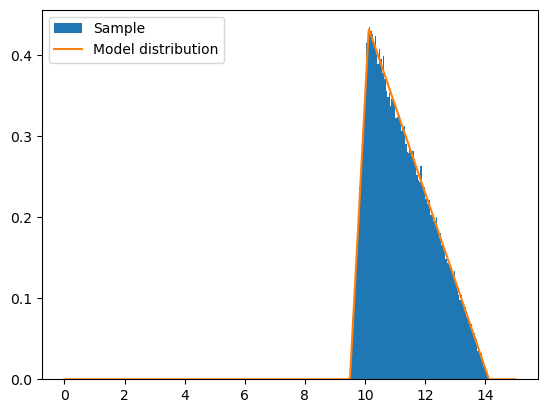

In [22]:
amps = [rollAmp(P_test, E_test) for i in range(100000)]
plt.hist(amps, bins=100, density=True, label='Sample')
plt.plot(E_test, P_test, label='Model distribution')
plt.legend()

### Utility &mdash; parallelize

In [23]:
from multiprocessing import Pool

if __name__ == "__main__":
    tasks = []

def runner(idx):
    np.random.seed()
    return tasks[idx]()

def runInParallel(amount, poolSize, what, *args, **kwargs):
    # Clean some of the old tasks
    global tasks
    
    while len(tasks) > 10:
        del tasks[0]
    
    idx = len(tasks)
    tasks.append(lambda: what(*args, **kwargs))
    with Pool(poolSize) as p:
        return p.map(runner, [ idx for i in range(amount) ])

In [24]:
%%timeit -n1 -r1
amps = runInParallel(100000, 128, rollAmp, P_test, E_test)

2.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [25]:
amps = runInParallel(100000, 128, rollAmp, P_test, E_test)

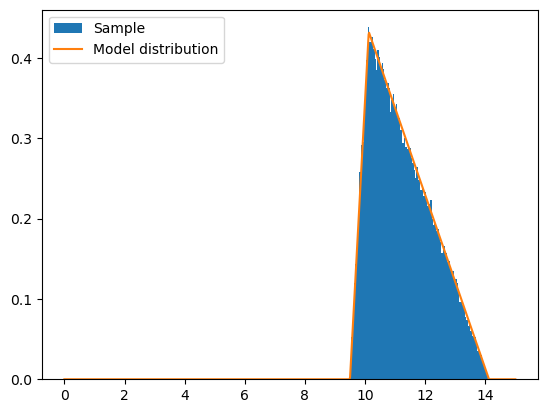

In [26]:
plt.hist(amps, bins=100, density=True, label='Sample')
plt.plot(E_test, P_test, label='Model distribution')
plt.legend()

With fast `numba`-accelerated functions this naive parallelization doesn't work very well since more time is spent creating processes than executing the function itself.

### Utility &mdash; `numba`-accelerated `for` loop for bulk execution

In [27]:
@njit
def numbaBulk(amount, what, *args): # **kwargs aren't supported by numba
    return [ what(*args) for i in range(amount) ]

### Bulk + parallel execution

In [28]:
%%timeit -n1 -r1
amps = runInParallel(100, None, numbaBulk, 1000, rollAmp, P_test, E_test)

324 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


100000 = 100000


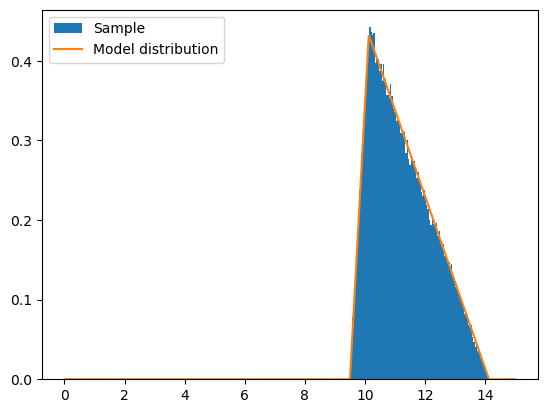

In [29]:
amps = runInParallel(100, None, numbaBulk, 1000, rollAmp, P_test, E_test)
amps = sum(amps, [])
print(f"{len(amps)} = 100000")
plt.hist(amps, bins=100, density=True, label='Sample')
plt.plot(E_test, P_test, label='Model distribution')
plt.legend()

## Complete roll

In [30]:
@njit
def testRollTwoPeaks(P, E, signal1, signal2, offsetLeft, offsetRight):
    offset = np.floor(np.random.uniform(0, 43))
    amp1 = rollAmp(P, E)
    amp2 = rollAmp(P, E)
    
    return np.array([
        offset,
        amp1,
        amp2,
        integrateSignalRelative(composeSignals(signal1, signal2, offset, amp1, amp2), offsetLeft, offsetRight)
    ])

In [31]:
testRollTwoPeaks(P_test, E_test, exampleSignal, exampleSignal, 3, 19)

array([ 38.        ,  12.61587879,  11.93351654, 119.75478152])

## Roll set histograms

In [32]:
numRolls = 10_000_000 # 1e+7

In [33]:
%%timeit -n1 -r1
runInParallel(100, None, numbaBulk, numRolls / 100, testRollTwoPeaks, P_test, E_test, exampleSignal, exampleSignal, 6, 28)

30.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


_Variable names contain integration interval positions relative to first peak's position e.g. `resultInt3_19` corresponds to integration interval from $9-3=6$ to $9+19=28$._

In [34]:
resultInt3_19 = runInParallel(
                    100, None,
                    numbaBulk, numRolls / 100,
                    testRollTwoPeaks, P_test, E_test, exampleSignal, exampleSignal, 3, 19
                    )

In [35]:
resultInt6_26 = runInParallel(
                    100, None,
                    numbaBulk, numRolls / 100,
                    testRollTwoPeaks, P_test, E_test, exampleSignal, exampleSignal, 6, 26
                    )

In [36]:
resultInt6_34 = runInParallel(
                    100, None,
                    numbaBulk, numRolls / 100,
                    testRollTwoPeaks, P_test, E_test, exampleSignal, exampleSignal, 6, 34
                    )

In [37]:
def plot(result, desc):
    processed = np.array(sum(result, []))
    assert(processed.shape == (numRolls, 4))
    
    fig, ax = plt.subplots(2, 2, squeeze=True, figsize=(10,10))
    for i in range(2):
        for j in range(2):
            ax[i, j].set_box_aspect(1)
    ax[0,0].hist(processed[:,3], bins=1001, density=True)
    ax[0,0].set_title(f"{desc}: integral distribution")
    ax[0,1].hist(processed[:,0], bins=int(np.max(processed[:,0]) - np.min(processed[:,0]))+1)
    ax[0,1].set_title(f"{desc}: second peak offset distribution")
    ax[1,0].hist(processed[:,1], bins=1001, density=True)
    ax[1,0].set_title(f"{desc}: first peak amplitude distribution")
    ax[1,1].hist(processed[:,2], bins=1001, density=True)
    ax[1,1].set_title(f"{desc}: second peak amplitude distribution")

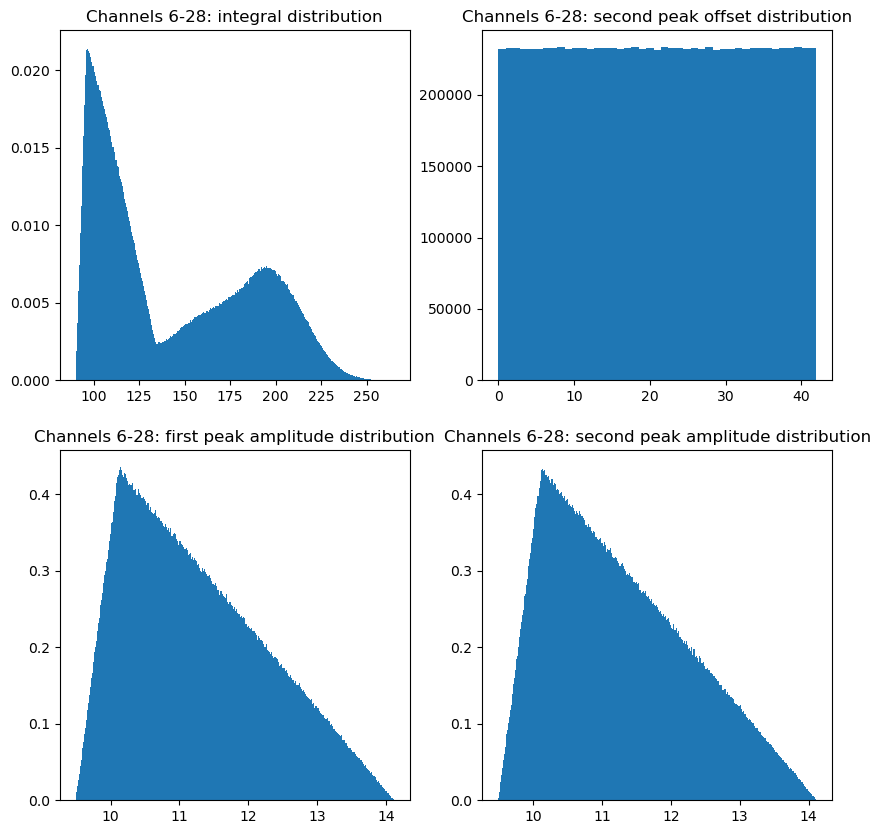

In [38]:
plot(resultInt3_19, "Channels 6-28")

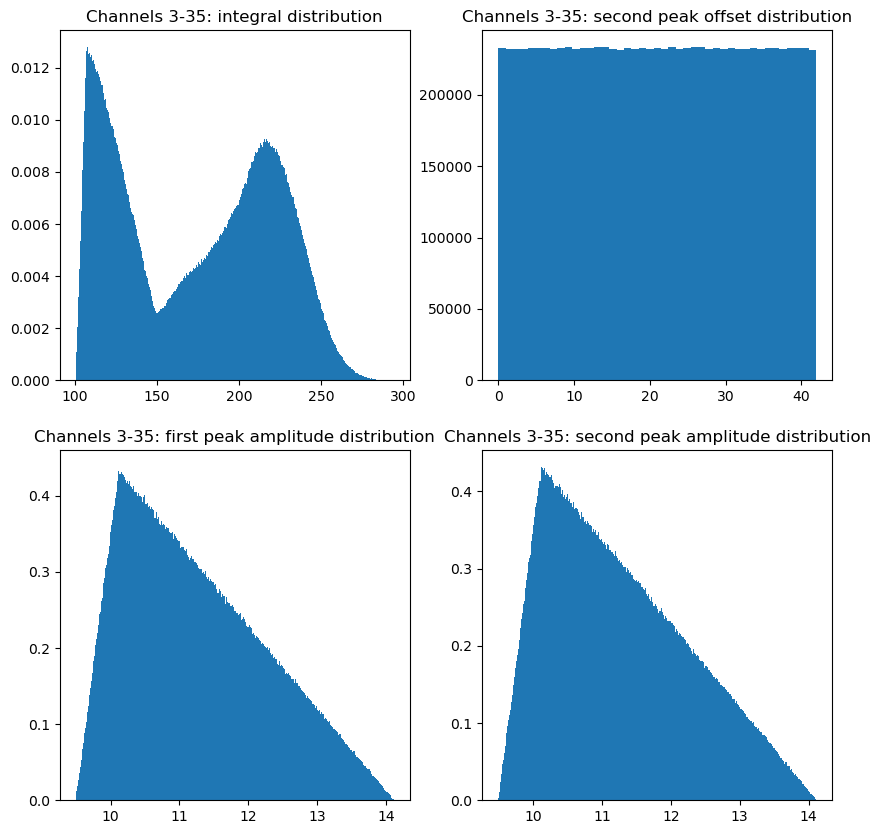

In [39]:
plot(resultInt6_26, "Channels 3-35")

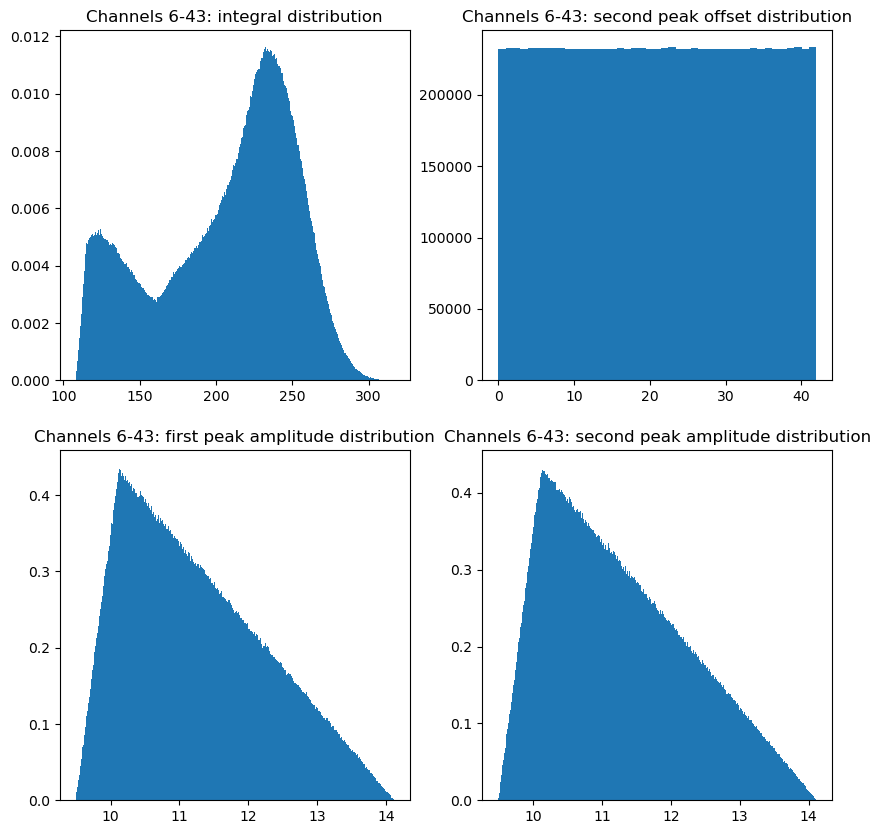

In [40]:
plot(resultInt6_34, "Channels 6-43")

## One peak roll

In [41]:
@njit
def testRollOnePeak(P, E, signal, offsetLeft, offsetRight):
    amp = rollAmp(P, E)
    
    return integrateSignalRelative(( signal[0].copy(), signal[1].copy() * amp ), offsetLeft, offsetRight)

In [42]:
numRollsOnePeak = 10_000 # 1e+4

In [43]:
onePeakResultInt3_19 = runInParallel(
                                100, None,
                                numbaBulk, numRollsOnePeak / 100,
                                testRollOnePeak, P_test, E_test, exampleSignal, 6, 28
                                )
onePeakResultInt3_19 = sum(onePeakResultInt3_19, [])
assert(len(onePeakResultInt3_19) == numRollsOnePeak)

In [44]:
onePeakResultInt6_26 = runInParallel(
                                100, None,
                                numbaBulk, numRollsOnePeak / 100,
                                testRollOnePeak, P_test, E_test, exampleSignal, 3, 35
                                )
onePeakResultInt6_26 = sum(onePeakResultInt6_26, [])

In [45]:
onePeakResultInt6_34 = runInParallel(
                                100, None,
                                numbaBulk, numRollsOnePeak / 100,
                                testRollOnePeak, P_test, E_test, exampleSignal, 3, 43
                                )
onePeakResultInt6_34 = sum(onePeakResultInt6_34, [])

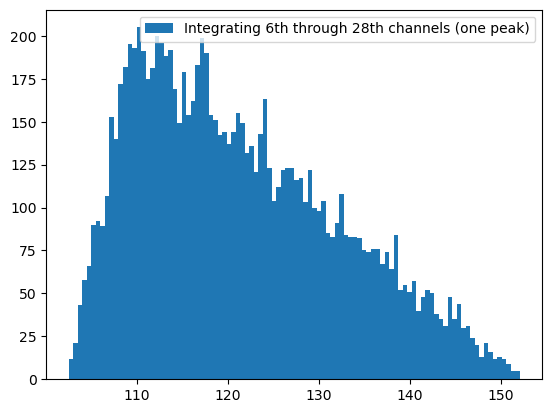

In [46]:
plt.hist(onePeakResultInt3_19, bins=100, label="Integrating 6th through 28th channels (one peak)")
plt.legend()

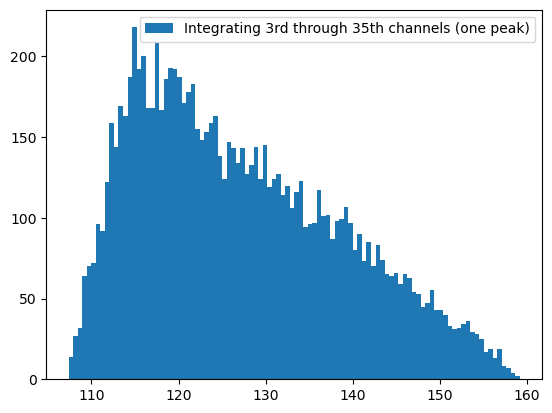

In [47]:
plt.hist(onePeakResultInt6_26, bins=100, label="Integrating 3rd through 35th channels (one peak)")
plt.legend()

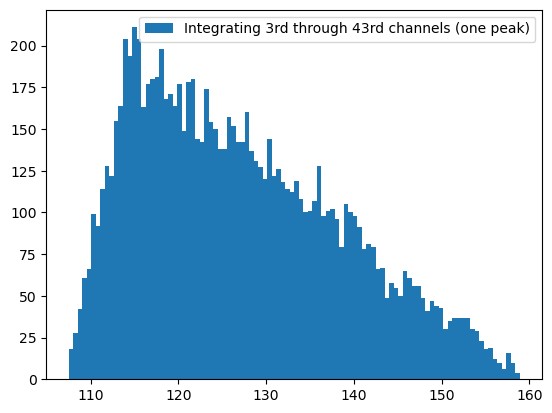

In [48]:
plt.hist(onePeakResultInt6_34, bins=100, label="Integrating 3rd through 43rd channels (one peak)")
plt.legend()

## Experimental amplitude distribution

### Load signal shapes

In [49]:
"""
Loads a signal shape from Numass experimental data file
Uses tabs by default, changed with `separator`
"""
def loadExperimentalSignalShape(filename, separator='\t'):
    signal = ( [], [] )
    with open(filename) as sigFile:
        header = True
        for line in sigFile.readlines():
            if header:
                header = False
                continue
                
            point = list(
                map(
                    lambda x: float(x),
                    line.split(separator)
                )
            )
            
            signal[0].append(float(point[0]))
            signal[1].append(float(sum(point[1:])))
    signal = ( np.array(signal[0]), np.array(signal[1]) )
    return signal

In [50]:
def processFile(filename):
    (E, P) = loadExperimentalSignalShape(filename)
    P = probNormalize(E, P)
    plt.plot(E, P, label="Amplitude distribution")
    plt.legend()
    
    numRolls = 10_000_000 # 1e+7
    
    resultInt3_19 = runInParallel(
                        100, None,
                        numbaBulk, numRolls / 100,
                        testRollTwoPeaks, P, E, exampleSignal, exampleSignal, 3, 19
                        )
    resultInt6_26 = runInParallel(
                        100, None,
                        numbaBulk, numRolls / 100,
                        testRollTwoPeaks, P, E, exampleSignal, exampleSignal, 6, 26
                        )
    resultInt6_34 = runInParallel(
                        100, None,
                        numbaBulk, numRolls / 100,
                        testRollTwoPeaks, P, E, exampleSignal, exampleSignal, 6, 34
                        )
    
    plot(resultInt3_19, "Channels 6-28")
    plot(resultInt6_26, "Channels 3-35")
    plot(resultInt6_34, "Channels 6-43")

In [ ]:
processFile('task/data/p120(30s)(HV1=12000).txt')

PInt=75168.75000000004


In [ ]:
processFile('task/data/p120(30s)(HV1=12500).txt')

PInt=75168.75000000004


In [ ]:
processFile('task/data/p120(30s)(HV1=13000).txt')

PInt=75168.75000000004


In [ ]:
processFile('task/data/p120(30s)(HV1=13500).txt')

PInt=75168.75000000004


In [ ]:
processFile('task/data/p120(30s)(HV1=14000).txt')

PInt=75168.75000000004
